<a href="https://colab.research.google.com/github/RBorczuch/PlatesOCR/blob/main/PlatesOCR_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#OCR (Optical Character Recognition) do odczytywania tablic rejestracyjnych.
## Wprowadzenie
Program ten demonstruje zastosowanie technologii OCR do dekodowania tablic rejestracyjnych. Wykorzystuje bibliotekę Keras do stworzenia i wytrenowania sieci neuronowej na obrazach tablic rejestracyjnych, które zostały wcześniej odpowiednio przygotowane.


## Importowanie bibliotek.

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from pathlib import Path
from collections import Counter

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers


In [ ]:
#!unzip -qq plates_images.zip -d plates_images
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
tf.debugging.set_log_device_placement(True)

Num GPUs Available:  1


##Przygotowanie danych:

**Ten kod przygotowuje dane do trenowania modelu OCR (Optical Character Recognition) na obrazach tablic rejestracyjnych. Składa się z kilku etapów:**

1. **Definicja wymiarów obrazów:** Ustawienie nowych wymiarów obrazów na 200x50
pikseli.

2. **Funkcja pad_labels:** Funkcja do dopełniania etykiet (tekstów z tablic rejestracyjnych) spacjami do określonej maksymalnej długości.

3. **Funkcja encode_single_sample:** Funkcja do przetwarzania pojedynczego obrazu. Odczytuje obraz, konwertuje go na skalę szarości, normalizuje, zmienia jego rozmiar, transponuje oraz konwertuje etykietę tekstową na numeryczne wartości.

4. **Funkcja split_data:** Funkcja do podziału danych na zbiór treningowy i walidacyjny. Dzieli dane w proporcji 80% do 20% i opcjonalnie je miesza.

5. **Przygotowanie danych:** Odczytuje wszystkie obrazy z katalogu plates_images, usuwa spacje z nazw plików, tworzy etykiety i zbiór unikalnych znaków (w tym dodaje spację), określa maksymalną długość etykiet, konwertuje etykiety na listy liczb, dopełnia je spacjami do maksymalnej długości oraz konwertuje z powrotem na ciągi znaków.

6. Na końcu kod drukuje liczbę znalezionych obrazów, etykiet, unikalnych znaków oraz wyświetla listę tych znaków.

In [ ]:

# Definicja nowych wymiarów obrazów
img_width = 200
img_height = 50

# Funkcja do dopełniania etykiet spacjami
def pad_labels(labels, max_length):
    padded_labels = []
    for label in labels:
        padded_label = label + [ord(' ')] * (max_length - len(label))
        padded_labels.append(padded_label)
    return padded_labels

# Funkcja do kodowania pojedynczego przykładu
def encode_single_sample(img_path, label):
    # 1. Read image
    img = tf.io.read_file(img_path)
    # 2. Decode and convert to grayscale
    img = tf.io.decode_jpeg(img, channels=1)
    # 3. Convert to float32 in [0, 1] range
    img = tf.image.convert_image_dtype(img, tf.float32)
    # 4. Resize to the desired size
    img = tf.image.resize(img, [img_height, img_width])
    # 5. Transpose the image because we want the time
    # dimension to correspond to the width of the image.
    img = tf.transpose(img, perm=[1, 0, 2])
    # 6. Map the characters in label to numbers
    label = tf.strings.unicode_split(label, input_encoding="UTF-8")
    label = char_to_num(label)
    # 7. Return a dict as our model is expecting two inputs
    return {"image": img, "label": label}

# Funkcja do podziału danych na zbiór treningowy i walidacyjny
def split_data(images, labels, train_size=0.8, shuffle=True):
    size = len(images)
    indices = np.arange(size)
    if shuffle:
        np.random.shuffle(indices)
    train_samples = int(size * train_size)
    x_train, y_train = images[indices[:train_samples]], labels[indices[:train_samples]]
    x_valid, y_valid = images[indices[train_samples:]], labels[indices[train_samples:]]
    return x_train, x_valid, y_train, y_valid

# Ścieżka do katalogu z danymi
data_dir = Path("./plates_images/")

# Pobranie listy wszystkich obrazów
images = sorted(list(map(str, list(data_dir.glob("*.jpg")))))

# Usuń spacje z nazw plików i uzyskaj etykiety
labels = [img.split(os.path.sep)[-1].replace(" ", "").split(".jpg")[0] for img in images]

# Utwórz zbiór unikalnych znaków z etykiet
characters = sorted(set(char for label in labels for char in label))
characters.append(' ')  # Dodajemy spację do zestawu znaków

# Maximum length of any captcha in the dataset
max_length = max([len(label) for label in labels])

# Konwersja etykiet na listy liczb (kodowanie znaków)
labels_num = [[ord(char) for char in label] for label in labels]

# Dopełnianie etykiet do maksymalnej długości spacjami
labels_padded = pad_labels(labels_num, max_length)

# Konwersja z powrotem na ciągi znaków (z dopełnieniem)
labels_str_padded = [''.join([chr(num) for num in label]) for label in labels_padded]

print("Number of images found:", len(images))
print("Number of labels found:", len(labels))
print("Number of unique characters:", len(characters))
print("Characters present:", characters)

# Konwersja obrazów i etykiet do tensorów
x_train, x_valid, y_train, y_valid = split_data(np.array(images), np.array(labels_str_padded))

# Mapping characters to integers
char_to_num = layers.StringLookup(
    vocabulary=list(characters), mask_token=None
)

# Mapping integers back to original characters
num_to_char = layers.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), mask_token=None, invert=True
)





Number of images found: 250
Number of labels found: 250
Number of unique characters: 34
Characters present: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'R', 'S', 'T', 'U', 'V', 'Y', 'Z', ' ']


##Przygotowanie danych treningowych:
Kod przygotowuje zestawy danych treningowych i walidacyjnych, przekształcając je w partie (batch) o rozmiarze 16. Używa funkcji encode_single_sample do kodowania danych, a tf.data.AUTOTUNE do automatycznego dostosowania liczby wątków i buforowania danych, aby zoptymalizować wydajność przetwarzania.

In [ ]:
# Przygotowanie zestawów danych
batch_size = 16  # Ustawienie wielkości partii

train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = (
    train_dataset.map(
        encode_single_sample, num_parallel_calls=tf.data.AUTOTUNE
    )
    .batch(batch_size)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

validation_dataset = tf.data.Dataset.from_tensor_slices((x_valid, y_valid))
validation_dataset = (
    validation_dataset.map(
        encode_single_sample, num_parallel_calls=tf.data.AUTOTUNE
    )
    .batch(batch_size)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)


## Wizualizacja danych:

Batch size (images): (16, 200, 50, 1)
Batch size (labels): (16, 8)


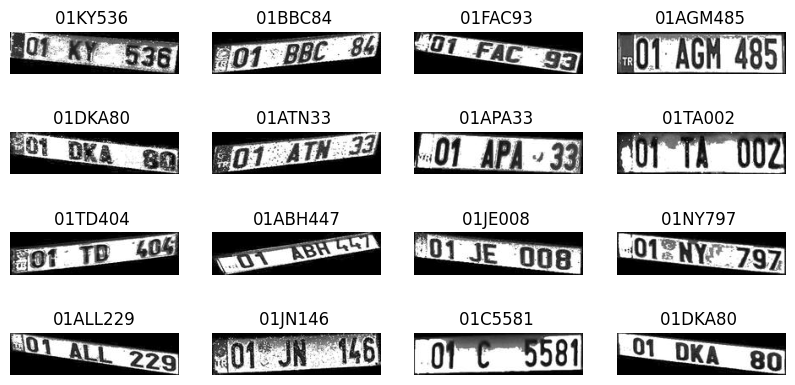

In [ ]:
# Wyświetlanie przykładowych obrazów z zestawu treningowego
_, ax = plt.subplots(4, 4, figsize=(10, 5))
for batch in train_dataset.take(1):
    images = batch["image"]
    labels = batch["label"]
    print("Batch size (images):", images.shape)
    print("Batch size (labels):", labels.shape)
    for i in range(min(16, len(images))):  # Upewnij się, że nie przekraczasz liczby obrazów w partii
        img = (images[i] * 255).numpy().astype("uint8")
        label = tf.strings.reduce_join(num_to_char(labels[i])).numpy().decode("utf-8")
        ax[i // 4, i % 4].imshow(img[:, :, 0].T, cmap="gray")
        ax[i // 4, i % 4].set_title(label)
        ax[i // 4, i % 4].axis("off")
plt.show()

## Model:
**CTCLayer**
Klasa CTCLayer jest niestandardową warstwą Keras do obliczania straty CTC (Connectionist Temporal Classification). Podczas treningu, strata CTC jest obliczana i dodawana do modelu, a podczas testowania zwracane są przewidywania.

**build_model**
Funkcja build_model definiuje model OCR:

*   **Wejścia:** obrazy i etykiety.
*   **Bloki konwolucyjne:** dwa bloki konwolucyjne z warstwami MaxPooling.
*   **RNN:** dwukierunkowe warstwy LSTM.
*   **Warstwa wyjściowa:** warstwa Dense z aktywacją softmax.
*   **Warstwa CTC:** dodanie niestandardowej warstwy CTC do obliczania straty.
*   Model jest kompilowany z użyciem optymalizatora **Adam** i zwracany.

In [ ]:
class CTCLayer(layers.Layer):
    def __init__(self, name=None):
        super().__init__(name=name)
        self.loss_fn = keras.backend.ctc_batch_cost

    def call(self, y_true, y_pred):
        # Oblicz wartość straty podczas treningu i dodaj ją
        # do warstwy za pomocą `self.add_loss()`.
        batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
        input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
        label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

        input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

        loss = self.loss_fn(y_true, y_pred, input_length, label_length)
        self.add_loss(loss)

        # Podczas testowania, zwróć jedynie obliczone przewidywania
        return y_pred

def build_model():
    # Wejścia do modelu
    input_img = layers.Input(
        shape=(img_width, img_height, 1), name="image", dtype="float32"
    )
    labels = layers.Input(name="label", shape=(None,), dtype="float32")

    # Pierwszy blok konwolucyjny
    x = layers.Conv2D(
        32,
        (3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="Conv1",
    )(input_img)
    x = layers.MaxPooling2D((2, 2), name="pool1")(x)

    # Drugi blok konwolucyjny
    x = layers.Conv2D(
        64,
        (3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="Conv2",
    )(x)
    x = layers.MaxPooling2D((2, 2), name="pool2")(x)

    # Użyliśmy dwóch max pool z rozmiarem puli i krokiem 2.
    # Dlatego zmniejszone mapy cech są 4x mniejsze. Liczba
    # filtrów w ostatniej warstwie wynosi 64. Przekształć odpowiednio przed
    # przekazaniem wyjścia do części RNN modelu
    new_shape = ((img_width // 4), (img_height // 4) * 64)
    x = layers.Reshape(target_shape=new_shape, name="reshape")(x)
    x = layers.Dense(64, activation="relu", name="dense1")(x)
    x = layers.Dropout(0.2)(x)

    # RNN
    x = layers.Bidirectional(layers.LSTM(128, return_sequences=True, dropout=0.25))(x)
    x = layers.Bidirectional(layers.LSTM(64, return_sequences=True, dropout=0.25))(x)

    # Warstwa wyjściowa
    x = layers.Dense(
        len(char_to_num.get_vocabulary()) + 1, activation="softmax", name="dense2"
    )(x)

    # Dodaj warstwę CTC do obliczania straty CTC na każdym kroku
    output = CTCLayer(name="ctc_loss")(labels, x)

    # Zdefiniuj model
    model = keras.models.Model(
        inputs=[input_img, labels], outputs=output, name="ocr_model_v1"
    )
    # Optymalizator
    opt = keras.optimizers.Adam()
    # Skompiluj model i zwróć
    model.compile(optimizer=opt)
    return model

# Pobierz model
model = build_model()
model.summary()


Model: "ocr_model_v1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 image (InputLayer)          [(None, 200, 50, 1)]         0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 200, 50, 32)          320       ['image[0][0]']               
                                                                                                  
 pool1 (MaxPooling2D)        (None, 100, 25, 32)          0         ['Conv1[0][0]']               
                                                                                                  
 Conv2 (Conv2D)              (None, 100, 25, 64)          18496     ['pool1[0][0]']               
                                                                                       

## Trenowanie:
Kod trenuje model przez maksymalnie 200 epok, z użyciem wczesnego zatrzymania (early stopping) po 50 epokach bez poprawy val_loss. Dodatkowo, najlepszy model jest zapisywany do pliku best_model.h5 na podstawie wartości val_loss.

*   **Wczesne zatrzymanie:** Zatrzymuje trening, gdy val_loss nie poprawia się przez 50 epok, przywracając najlepsze wagi.
*   **Zapis modelu:** Zapisuje najlepszy model podczas treningu.
*   **Trenowanie modelu:** Wykonuje trening modelu na danych treningowych i walidacyjnych z określonymi callbackami.

In [43]:
# Ustawienia treningu
epochs = 300
early_stopping_patience = 30

# Dodaj wczesne zatrzymanie
early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=early_stopping_patience, restore_best_weights=True
)

# Dodaj callback do zapisywania modelu podczas treningu
model_checkpoint = keras.callbacks.ModelCheckpoint(
    filepath="best_model.h5",
    monitor="val_loss",
    save_best_only=True,
    save_weights_only=False,
    mode='auto'
)

# Przygotowanie danych (ten fragment zakłada, że masz już przygotowane train_dataset i validation_dataset)
# ...

# Trenowanie modelu
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=epochs,
    callbacks=[early_stopping, model_checkpoint],
)

# Zapisanie ostatecznej wersji modelu po treningu
model.save('final_model.h5')


Epoch 1/300
13/13 [==============================] - 1s 61ms/step - loss: 0.1390 - val_loss: 2.4330
Epoch 2/300
13/13 [==============================] - 1s 41ms/step - loss: 0.1403 - val_loss: 2.3067
Epoch 3/300
13/13 [==============================] - 1s 46ms/step - loss: 0.1301 - val_loss: 2.2925
Epoch 4/300
13/13 [==============================] - 1s 51ms/step - loss: 0.1356 - val_loss: 2.3267
Epoch 5/300
13/13 [==============================] - 1s 62ms/step - loss: 0.1131 - val_loss: 2.2015
Epoch 6/300
13/13 [==============================] - 0s 37ms/step - loss: 0.1136 - val_loss: 2.2132
Epoch 7/300
13/13 [==============================] - 1s 43ms/step - loss: 0.1539 - val_loss: 2.0971
Epoch 8/300
13/13 [==============================] - 0s 34ms/step - loss: 0.1516 - val_loss: 2.2349
Epoch 9/300
13/13 [==============================] - 0s 36ms/step - loss: 0.1194 - val_loss: 2.2037
Epoch 10/300
13/13 [==============================] - 0s 33ms/step - loss: 0.1328 - val_loss: 2.3344

## Wnioskowanie:

Kod tworzy model predykcji, dekoduje wyniki predykcji i wyświetla je na kilku próbkach walidacyjnych.

*   **Model predykcji:** Tworzy model predykcji, wyodrębniając warstwy od wejściowej do wyjściowej warstwy dense2.
*   **Dekodowanie wyników:** Funkcja decode_batch_predictions dekoduje wyniki sieci, przekształcając je na tekst.
*   **Wizualizacja wyników:** Wyświetla obrazy i ich przewidywane etykiety na próbkach walidacyjnych, porównując z oryginalnymi etykietami.

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 image (InputLayer)          [(None, 200, 50, 1)]      0         
                                                                 
 Conv1 (Conv2D)              (None, 200, 50, 32)       320       
                                                                 
 pool1 (MaxPooling2D)        (None, 100, 25, 32)       0         
                                                                 
 Conv2 (Conv2D)              (None, 100, 25, 64)       18496     
                                                                 
 pool2 (MaxPooling2D)        (None, 50, 12, 64)        0         
                                                                 
 reshape (Reshape)           (None, 50, 768)           0         
                                                                 
 dense1 (Dense)              (None, 50, 64)            4921

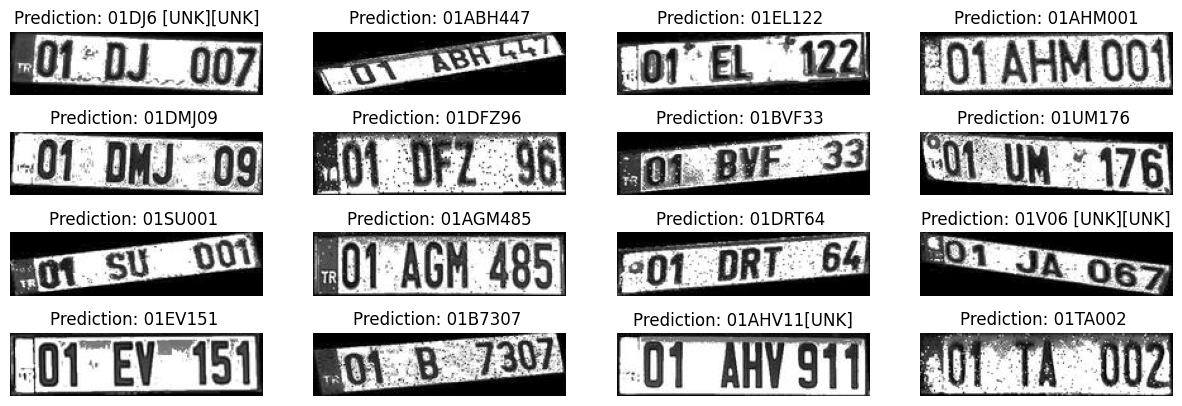

In [ ]:
# Uzyskaj model predykcji, wyodrębniając warstwy do warstwy wyjściowej
prediction_model = keras.models.Model(
    model.get_layer(name="image").input, model.get_layer(name="dense2").output
)
prediction_model.summary()

# Funkcja pomocnicza do dekodowania wyników sieci
def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    # Użyj wyszukiwania zachłannego. Dla bardziej złożonych zadań można użyć wyszukiwania wiązkowego (beam search)
    results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0][
        :, :max_length
    ]
    # Iteruj po wynikach i przekształcaj je z powrotem na tekst
    output_text = []
    for res in results:
        res = tf.strings.reduce_join(num_to_char(res)).numpy().decode("utf-8")
        output_text.append(res)
    return output_text

# Sprawdźmy wyniki na kilku próbkach walidacyjnych
for batch in validation_dataset.take(1):
    batch_images = batch["image"]
    batch_labels = batch["label"]

    preds = prediction_model.predict(batch_images)
    pred_texts = decode_batch_predictions(preds)

    orig_texts = []
    for label in batch_labels:
        label = tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
        orig_texts.append(label)

    _, ax = plt.subplots(4, 4, figsize=(15, 5))
    for i in range(len(pred_texts)):
        img = (batch_images[i, :, :, 0] * 255).numpy().astype(np.uint8)
        img = img.T
        title = f"Prediction: {pred_texts[i]}"
        ax[i // 4, i % 4].imshow(img, cmap="gray")
        ax[i // 4, i % 4].set_title(title)
        ax[i // 4, i % 4].axis("off")
plt.show()


In [ ]:
import shutil
from pathlib import Path
from google.colab import files

# Ścieżka do katalogu z danymi
data_dir = Path("./plates_images")

# Nazwa pliku ZIP
zip_filename = "plates_images.zip"

# Kompresja folderu plates_images do pliku ZIP
shutil.make_archive(zip_filename.replace('.zip', ''), 'zip', data_dir)

# Pobieranie pliku ZIP
files.download(zip_filename)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>